## Ishan Singh
## MDS202118

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import Libraries
import os
import numpy as np
import random
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
from sklearn.metrics import classification_report

In [3]:
# Define datapaths
train_dir = '/content/drive/My Drive/AML/chicken_duck_data/train'
validation_dir = '/content/drive/My Drive/AML/chicken_duck_data/val'
test_dir = '/content/drive/My Drive/AML/chicken_duck_data/test'

In [4]:
# Define data transformations for training, validation, and testing sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# Create image datasets, dataloaders, dataset sizes and class names
image_datasets = {x: datasets.ImageFolder(os.path.join('/content/drive/My Drive/AML/chicken_duck_data', x), data_transforms[x]) for x in ['train', 'val', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=2) for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

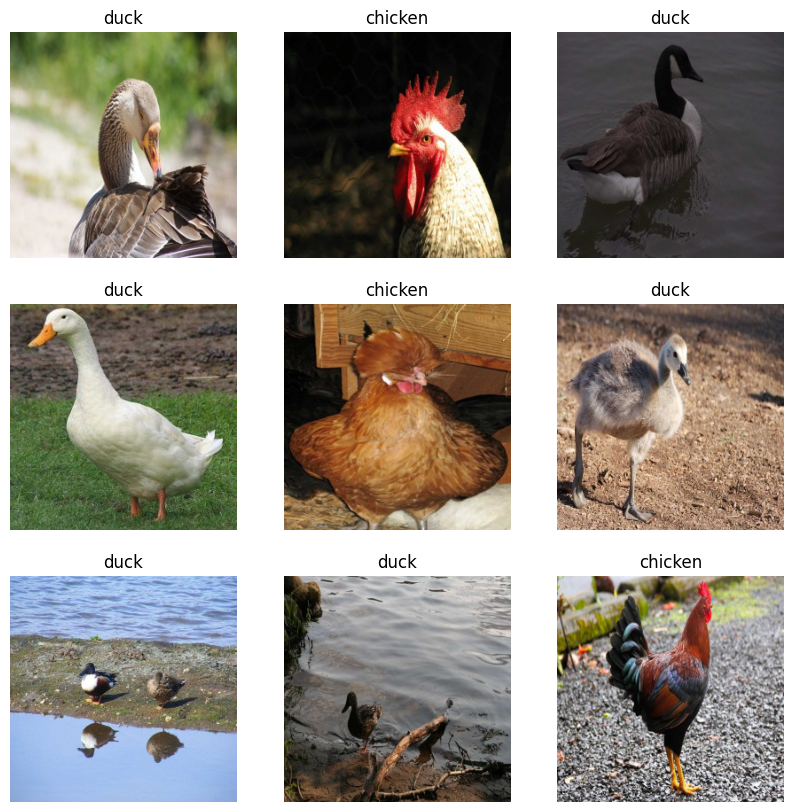

In [6]:
# Create image datasets
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'val': datasets.ImageFolder(validation_dir, data_transforms['val']),
    'test': datasets.ImageFolder(validation_dir, data_transforms['test'])
}

# Create data loaders
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=9, shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=9, shuffle=True, num_workers=2),
    'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=9, shuffle=False, num_workers=2)
}

# Display a few random images
inputs, classes = next(iter(dataloaders['train']))

def imshow(image, title=None):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    imshow(inputs[i])
    plt.title(class_names[classes[i]])
plt.show()

In [7]:
# Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            num_steps = len(dataloaders[phase])

            progress_bar = tqdm(enumerate(dataloaders[phase]), total=num_steps)

            for step, (inputs, labels) in progress_bar:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                progress_bar.set_description(f"{phase} - Loss: {loss.item():.4f}, Acc: {torch.mean((preds == labels.data).float()).item():.4f}")

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [8]:
# Load and modify ResNet18 model

from torchvision.models.resnet import resnet18, ResNet18_Weights

model_ft = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)

In [9]:
# Show model summary
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [10]:
# Set loss function, optimizer and learning rate scheduler
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [11]:
# Train the model
num_epochs = 10
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

Epoch 1/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.4424 Acc: 0.8008


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0877 Acc: 1.0000
Epoch 2/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.1330 Acc: 0.9553


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0515 Acc: 1.0000
Epoch 3/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.0925 Acc: 0.9675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0474 Acc: 1.0000
Epoch 4/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.0586 Acc: 0.9878


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0279 Acc: 1.0000
Epoch 5/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.1002 Acc: 0.9593


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0109 Acc: 1.0000
Epoch 6/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.0273 Acc: 0.9959


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0140 Acc: 1.0000
Epoch 7/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.0522 Acc: 0.9797


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0364 Acc: 1.0000
Epoch 8/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.0171 Acc: 0.9959


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0211 Acc: 1.0000
Epoch 9/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.0262 Acc: 0.9919


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0221 Acc: 1.0000
Epoch 10/10


  0%|          | 0/28 [00:00<?, ?it/s]

train Loss: 0.0241 Acc: 1.0000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.0128 Acc: 1.0000


In [12]:
# Function to test the model
def test_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []

    for inputs, labels in tqdm(dataloader):
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

    return y_true, y_pred

In [13]:
# Test the model
y_true, y_pred = test_model(model_ft, dataloaders['test'])
print(classification_report(y_true, y_pred, target_names=class_names))

  0%|          | 0/3 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     chicken       1.00      1.00      1.00        12
        duck       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



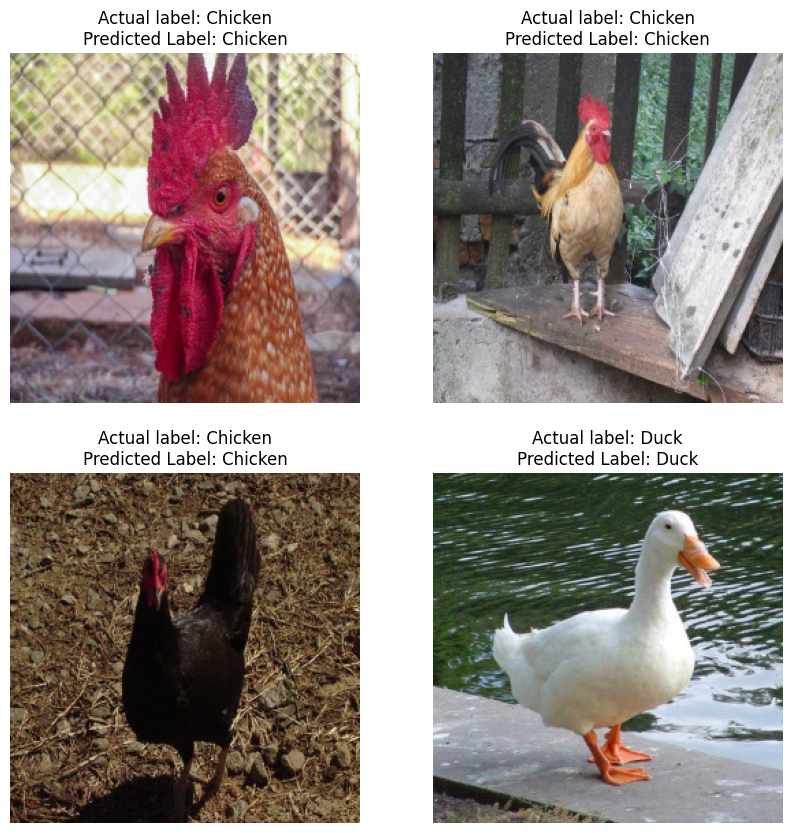

In [21]:
# Visualize predictions on 4 random test images

plt.figure(figsize=(10, 10))

# Revert normalization
def denormalize(image):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    return (image * std + mean).clip(0, 1)

for i in range(4):
    # Predict a random image from the test set
    test_image, test_label = random.choice(image_datasets['test'])
    test_image = test_image.unsqueeze(0)
    test_image = test_image.to(device)
    with torch.no_grad():
        output = model_ft(test_image)
        _, prediction = torch.max(output, 1)
        prediction = prediction.item()
    test_image = test_image.squeeze(0)

    # Plot the image with the caption
    plt.subplot(2, 2, i + 1)
    image_np = test_image.cpu().numpy().transpose((1, 2, 0))
    image_np = denormalize(image_np)
    plt.imshow(image_np)
    plt.title(f"Actual label: {class_names[test_label].capitalize()}\nPredicted Label: {class_names[prediction].capitalize()}")
    plt.axis('off')

plt.show()